In [9]:
# python3 -m venv AB_test_env
# !source AB_test_env/bin/activate
# %pip install -r ../requirements.txt

In [2]:
import numpy as np
import pandas as pd

import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
data_control_group = pd.read_csv('../data/control_group.csv', sep=';') 
data_test_group = pd.read_csv('../data/test_group.csv', sep=';')

data_control_group.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Control Campaign,1.08.2019,2280,82702.0,56930.0,7016.0,2290.0,2159.0,1819.0,618.0
1,Control Campaign,2.08.2019,1757,121040.0,102513.0,8110.0,2033.0,1841.0,1219.0,511.0
2,Control Campaign,3.08.2019,2343,131711.0,110862.0,6508.0,1737.0,1549.0,1134.0,372.0
3,Control Campaign,4.08.2019,1940,72878.0,61235.0,3065.0,1042.0,982.0,1183.0,340.0
4,Control Campaign,5.08.2019,1835,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Check for missing values
data_control_group.isnull().sum()
# data_test_group.isnull().sum()

# Remove missing values
data_control_group = data_control_group.dropna()
data_control_group.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29 entries, 0 to 29
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Campaign Name        29 non-null     object 
 1   Date                 29 non-null     object 
 2   Spend [USD]          29 non-null     int64  
 3   # of Impressions     29 non-null     float64
 4   Reach                29 non-null     float64
 5   # of Website Clicks  29 non-null     float64
 6   # of Searches        29 non-null     float64
 7   # of View Content    29 non-null     float64
 8   # of Add to Cart     29 non-null     float64
 9   # of Purchase        29 non-null     float64
dtypes: float64(7), int64(1), object(2)
memory usage: 2.5+ KB


In [4]:
# Convert date columns to datetime with dayfirst=True
data_control_group['Date'] = pd.to_datetime(data_control_group['Date'], dayfirst=True)
data_test_group['Date'] = pd.to_datetime(data_test_group['Date'], dayfirst=True)

# Check for duplicates
data_control_group.duplicated().sum()
data_test_group.duplicated().sum()

data_control_group.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29 entries, 0 to 29
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Campaign Name        29 non-null     object        
 1   Date                 29 non-null     datetime64[ns]
 2   Spend [USD]          29 non-null     int64         
 3   # of Impressions     29 non-null     float64       
 4   Reach                29 non-null     float64       
 5   # of Website Clicks  29 non-null     float64       
 6   # of Searches        29 non-null     float64       
 7   # of View Content    29 non-null     float64       
 8   # of Add to Cart     29 non-null     float64       
 9   # of Purchase        29 non-null     float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 2.5+ KB


In [5]:
unique_campaign_names_control = data_control_group['Campaign Name'].unique()
unique_campaign_names_test = data_test_group['Campaign Name'].unique()

print("Unique Campaign Names in Control Group:", unique_campaign_names_control)
print("Unique Campaign Names in Test Group:", unique_campaign_names_test)

Unique Campaign Names in Control Group: ['Control Campaign']
Unique Campaign Names in Test Group: ['Test Campaign']


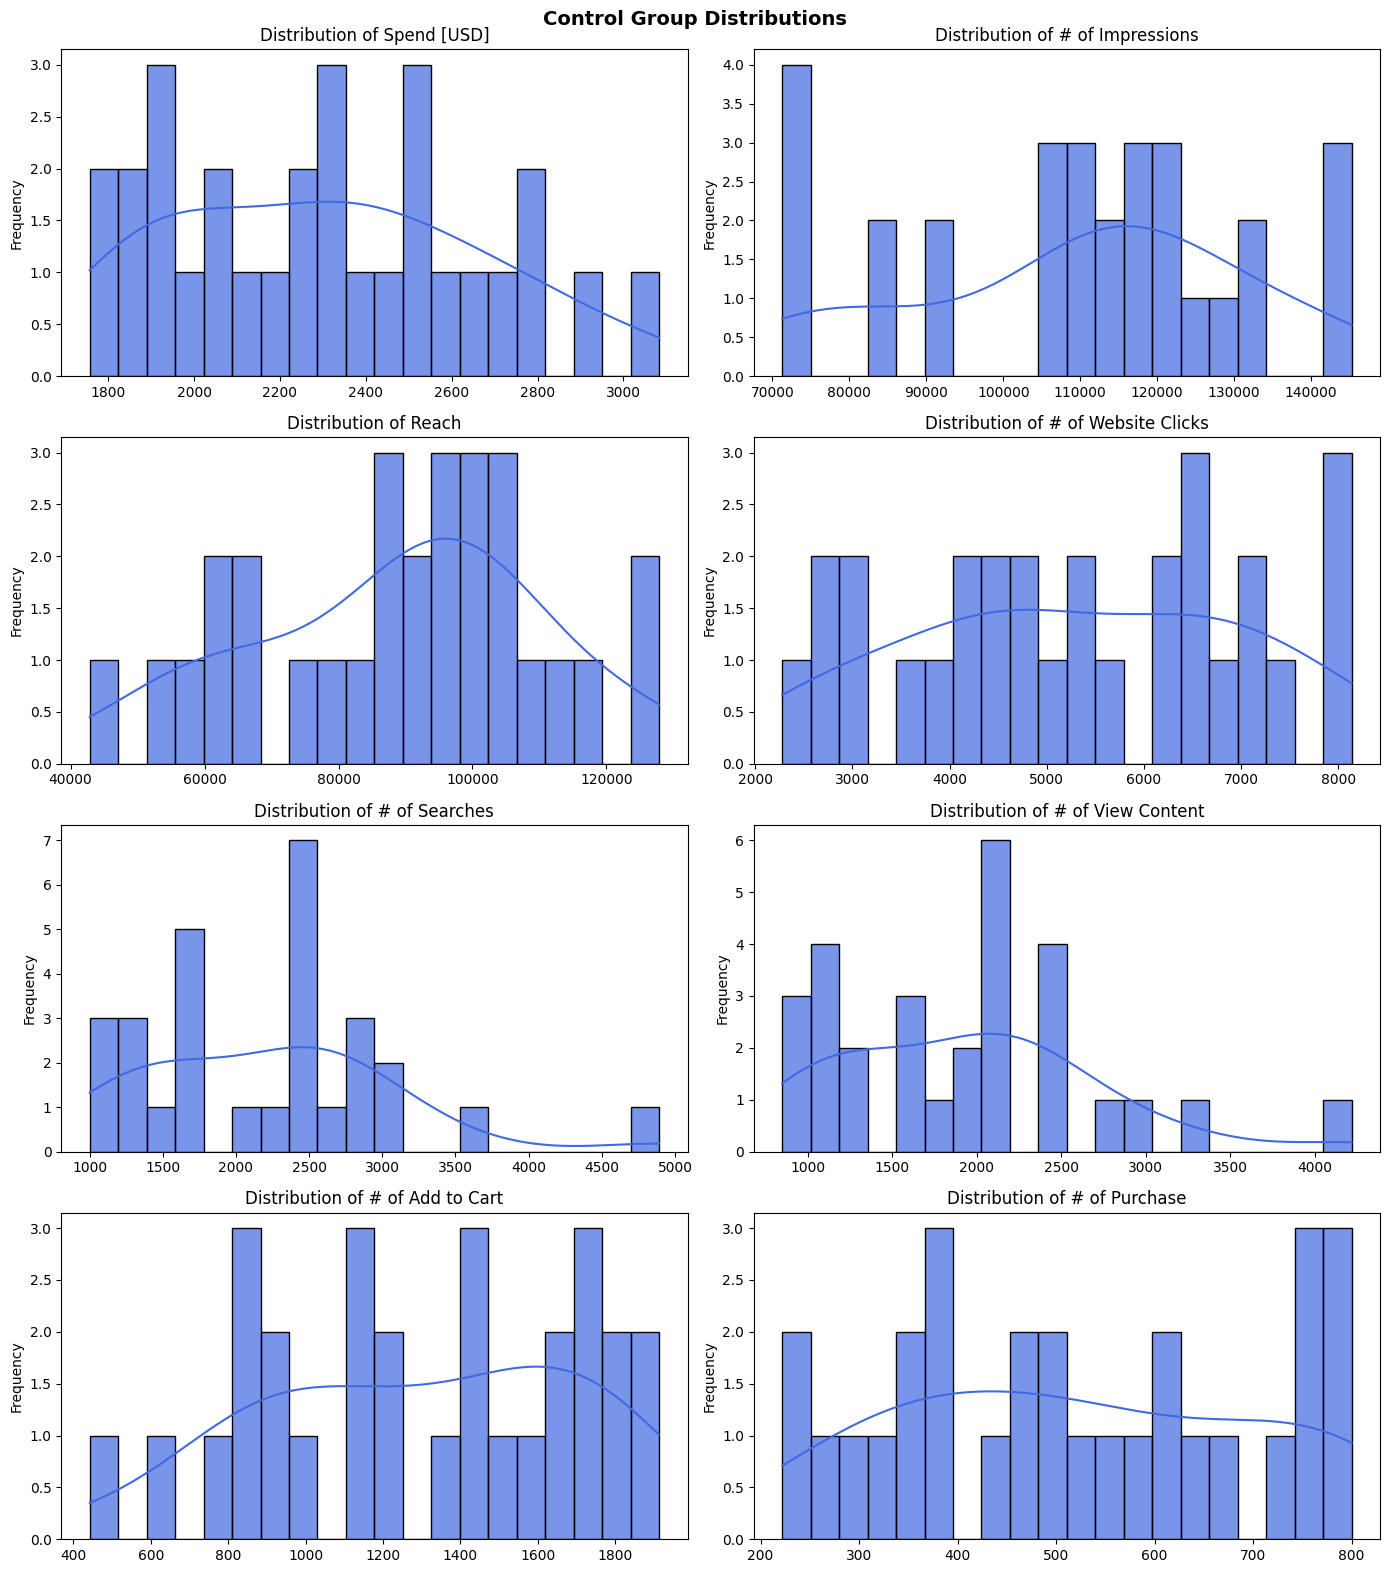

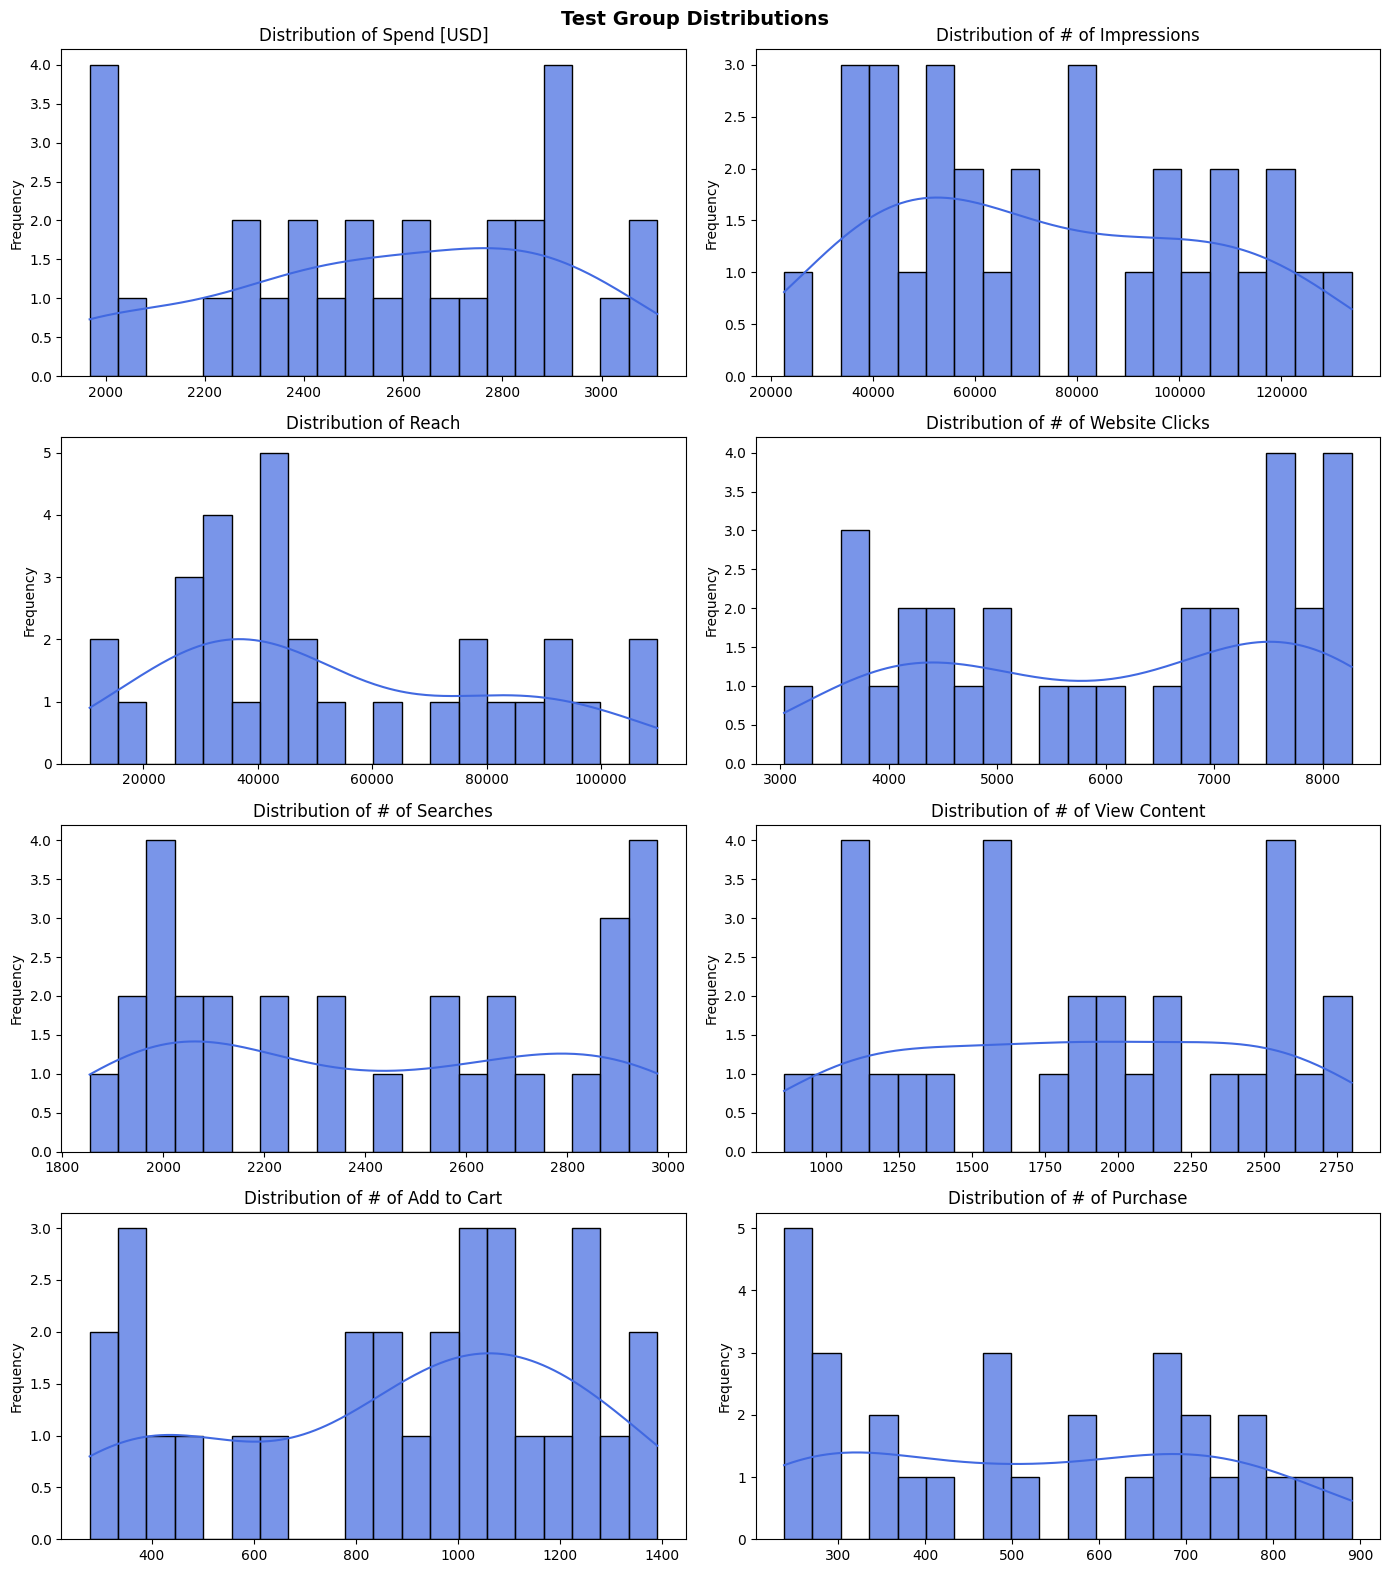

In [6]:
numerical_columns = data_control_group.select_dtypes(include=[np.number]).columns
def plot_distributions(data, title):
    num_cols = len(numerical_columns)
    rows = (num_cols // 2) + (num_cols % 2)  # Arrange in 2 columns
    fig, axes = plt.subplots(rows, 2, figsize=(14, rows * 4))
    axes = axes.flatten() if num_cols > 1 else [axes]

    for i, col in enumerate(numerical_columns):
        sns.histplot(data[col], kde=True, bins=20, ax=axes[i], color='royalblue', edgecolor='black', alpha=0.7)
        axes[i].set_title(f'Distribution of {col}', fontsize=12)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('Frequency')

    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

plot_distributions(data_control_group, 'Control Group Distributions')
plot_distributions(data_test_group, 'Test Group Distributions')

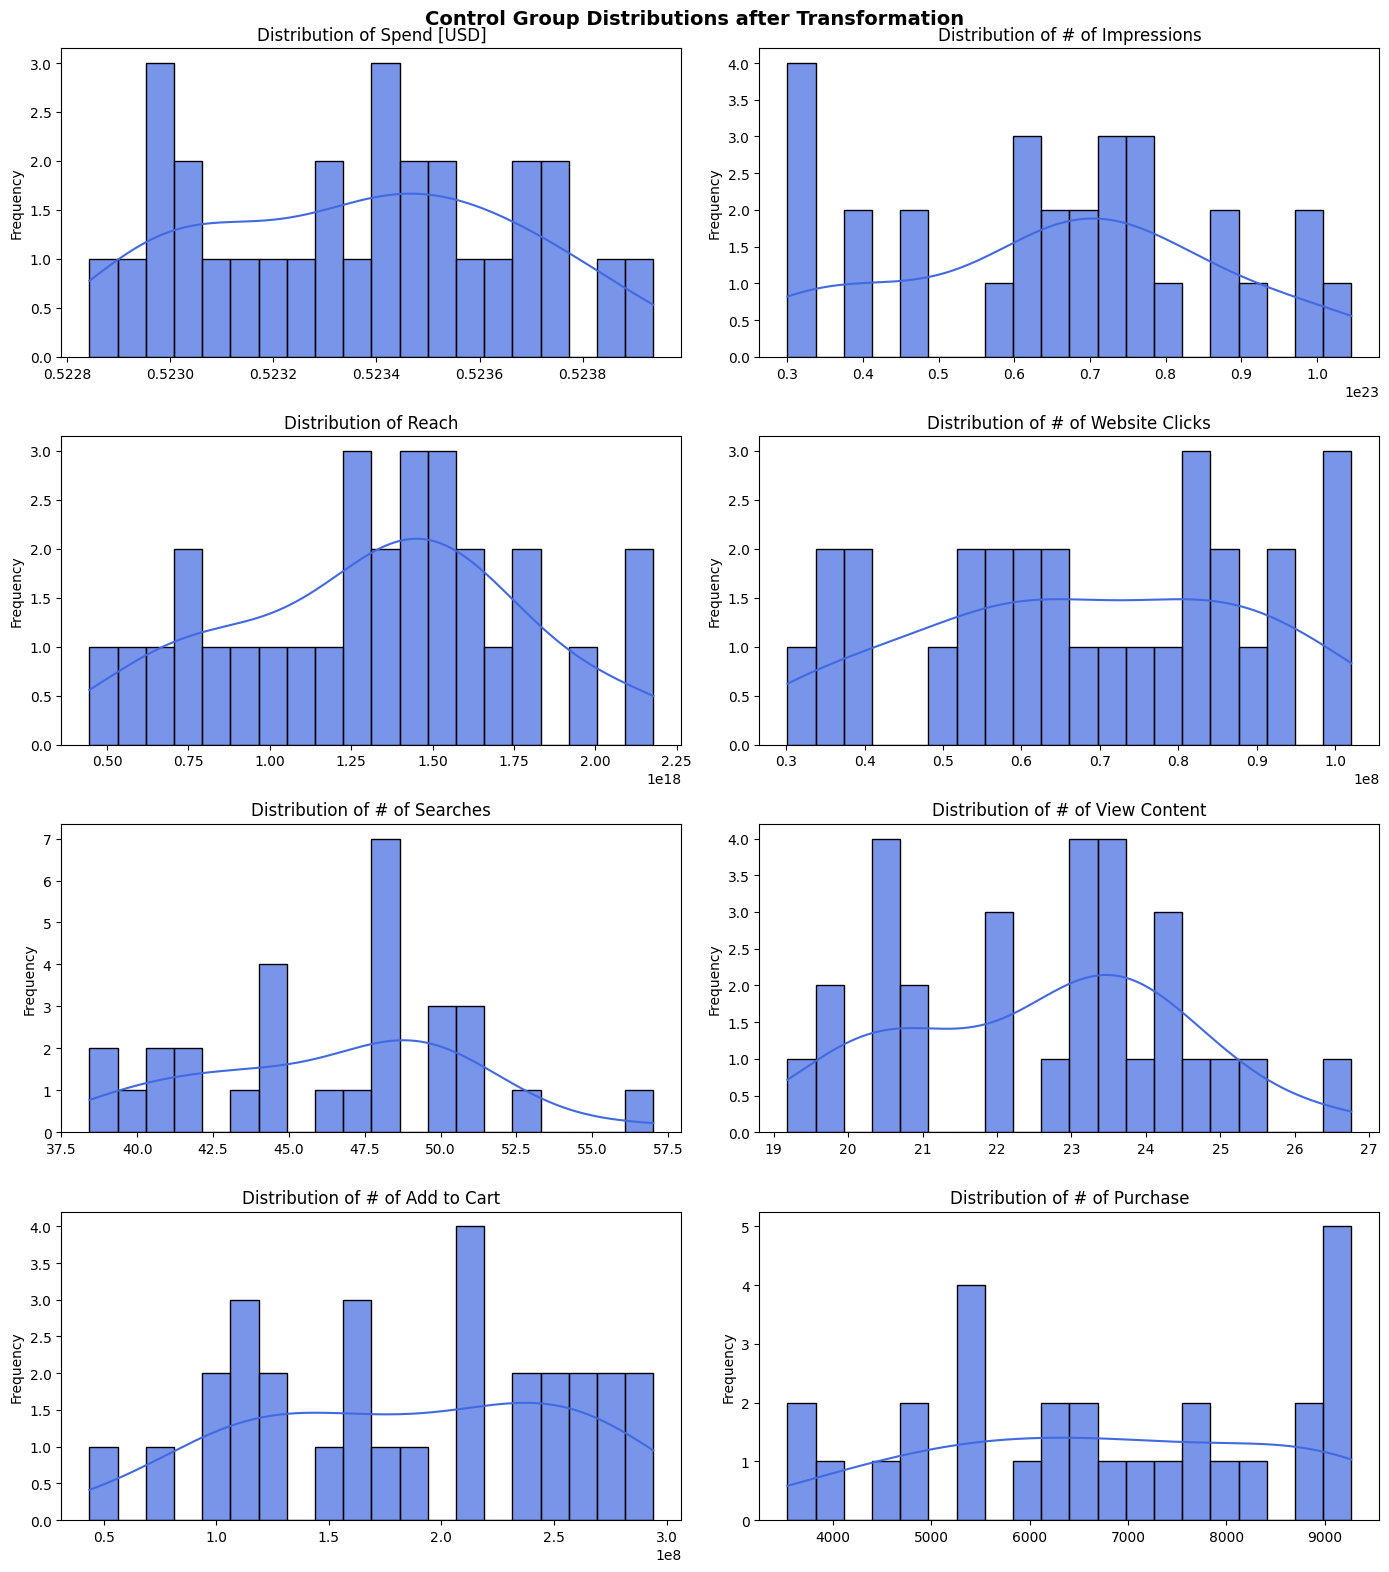

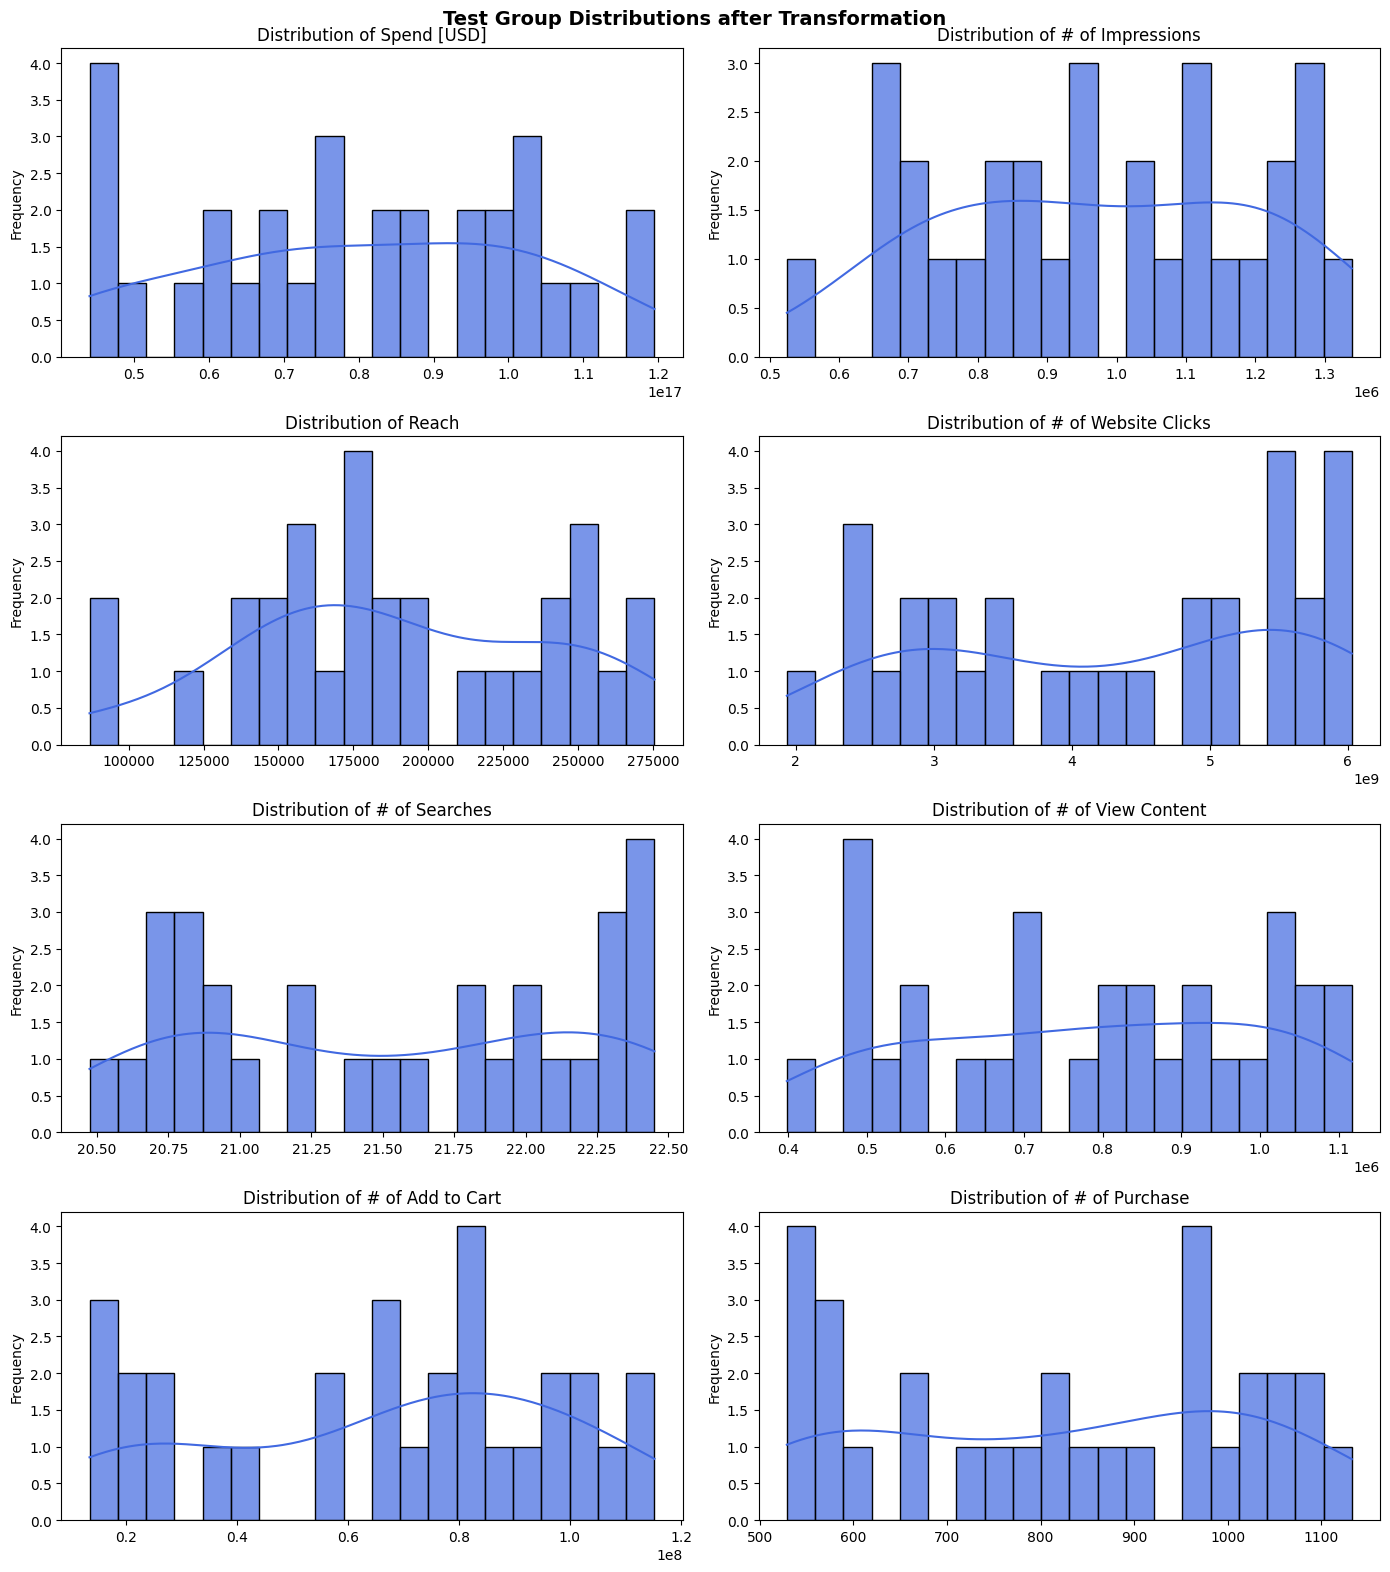

In [7]:
# Apply log1p transformation to numerical columns to solve skewness
data_control_group[numerical_columns] = data_control_group[numerical_columns].apply(np.log1p)
data_test_group[numerical_columns] = data_test_group[numerical_columns].apply(np.log1p)

# Apply Box-Cox transformation to numerical columns
for col in numerical_columns:
    data_control_group[col], _ = stats.boxcox(data_control_group[col] + 1)  # Adding 1 to avoid zero values
    data_test_group[col], _ = stats.boxcox(data_test_group[col] + 1)  # Adding 1 to avoid zero values

# Define a function to plot distributions using Seaborn
def plot_distributions(data, title):
    num_cols = len(numerical_columns)
    rows = (num_cols // 2) + (num_cols % 2)  # Arrange in 2 columns
    fig, axes = plt.subplots(rows, 2, figsize=(14, rows * 4))
    axes = axes.flatten() if num_cols > 1 else [axes]

    for i, col in enumerate(numerical_columns):
        sns.histplot(data[col], kde=True, bins=20, ax=axes[i], color='royalblue', edgecolor='black', alpha=0.7)
        axes[i].set_title(f'Distribution of {col}', fontsize=12)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('Frequency')

    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Plot transformed distributions
plot_distributions(data_control_group, 'Control Group Distributions after Transformation')
plot_distributions(data_test_group, 'Test Group Distributions after Transformation')


In [8]:
# save the datasets
data_control_group.to_csv('../data/transformed_control_group.csv', index=False)
data_test_group.to_csv('../data/transformed_test_group.csv', index=False)
